In [37]:
# Keras
!pip install keras_self_attention
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json, load_model
from keras.layers import Dense, Embedding, LSTM, Reshape, Bidirectional
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, Conv2D, MaxPooling2D
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation, Input, Dense, TimeDistributed)
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.utils import to_categorical, custom_object_scope
import tensorflow as tf
from tensorflow.keras import layers
#tf.keras.layers.Attention
# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# Other  
from tqdm import tqdm, tqdm_pandas
import scipy
from scipy.stats import skew
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import sys
import pickle
import IPython.display as ipd  # To play sound in the notebook
import warnings

# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [38]:
!pip install llvmlite==0.31.0

!pip install resampy

  Using cached llvmlite-0.31.0.tar.gz (110 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [34 lines of output]
      /opt/conda/lib/python3.10/site-packages/setuptools/__init__.py:80: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
      !!
      
              ********************************************************************************
              Requirements should be satisfied by a PEP 517 installer.
              If you are using pip, you can try `pip install --use-pep517`.
              ********************************************************************************
      
      !!
        dist.fetch_build_eggs(dist.setup_requires)
      LLVM version... Traceback (most recent call last):
        File "/tmp/pip-install-rtnp4e8x/llvmlite_8e574e6fad10402ab2ff4a1d474403bc/ffi/build.py", line 105, in main_posix
          out = su

# I. Load data

In [39]:
# Paths for data.
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

### Load Ravdess data to dataframe

In [40]:
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_path = []

source = []
for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        source.append('RAVDE')

emotion_df = pd.DataFrame(file_emotion, columns=['label'])
path_df = pd.DataFrame(file_path, columns=['path'])
source = pd.DataFrame(source, columns=['source'])
Ravdess_df = pd.concat([emotion_df, source, path_df], axis=1)
Ravdess_df['label'] = Ravdess_df['label'].replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
Ravdess_df.head()

,label,source,path
0,surprise,RAVDE,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,RAVDE,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,RAVDE,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,RAVDE,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,RAVDE,/kaggle/input/ravdess-emotional-speech-audio/a...


### Load Crema data to dataframe

In [41]:
crema_directory_list = os.listdir(Crema)
file_emotion = []
file_path = []
source = []
for file in crema_directory_list:
    file_path.append(Crema + file)
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
    source.append('CREMA')
emotion_df = pd.DataFrame(file_emotion, columns=['label'])
path_df = pd.DataFrame(file_path, columns=['path'])
source_df = pd.DataFrame(source, columns=['source'])
Crema_df = pd.concat([emotion_df, source_df, path_df], axis=1)
Crema_df.head()

,label,source,path
0,disgust,CREMA,/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1,happy,CREMA,/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2,happy,CREMA,/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3,disgust,CREMA,/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4,disgust,CREMA,/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav


### Load TESS data to dataframe

In [42]:
tess_directory_list = os.listdir(Tess)
file_emotion = []
file_path = []
source = []
for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        source.append('TESS')   
emotion_df = pd.DataFrame(file_emotion, columns=['label'])
path_df = pd.DataFrame(file_path, columns=['path'])
source_df = pd.DataFrame(source, columns=['source'])
Tess_df = pd.concat([emotion_df, source_df, path_df], axis=1)
Tess_df.head()

,label,source,path
0,fear,TESS,/kaggle/input/toronto-emotional-speech-set-tes...
1,fear,TESS,/kaggle/input/toronto-emotional-speech-set-tes...
2,fear,TESS,/kaggle/input/toronto-emotional-speech-set-tes...
3,fear,TESS,/kaggle/input/toronto-emotional-speech-set-tes...
4,fear,TESS,/kaggle/input/toronto-emotional-speech-set-tes...


### Load SAVEE data to dataframe

In [43]:
savee_directory_list = os.listdir(Savee)
file_emotion = []
file_path = []
source = []
for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
    source.append('SAVEE')
emotion_df = pd.DataFrame(file_emotion, columns=['label'])
path_df = pd.DataFrame(file_path, columns=['path'])
source_df = pd.DataFrame(source, columns=['source'])
Savee_df = pd.concat([emotion_df, source_df, path_df], axis=1)
Savee_df.head()

,label,source,path
0,happy,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
1,fear,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
2,happy,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
3,disgust,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
4,angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...


### Create a dataframe that consist all of type

In [44]:
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0, ignore_index = True)
ref = data_path.copy()
ref

,label,source,path
0,surprise,RAVDE,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,RAVDE,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,RAVDE,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,RAVDE,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,RAVDE,/kaggle/input/ravdess-emotional-speech-audio/a...
...,...,...,...
12157,surprise,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
12158,neutral,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
12159,neutral,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
12160,angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...


### Xem tín hiệu giọng nói và quang phổ

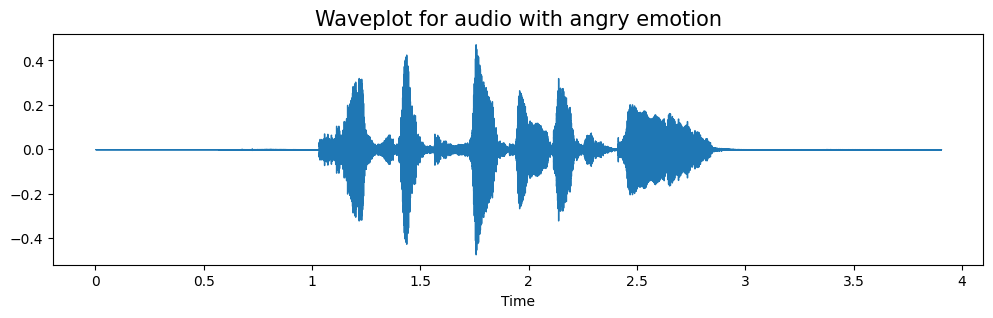

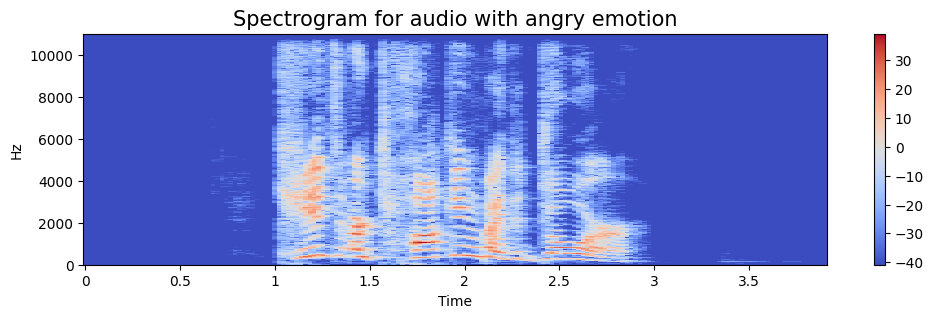

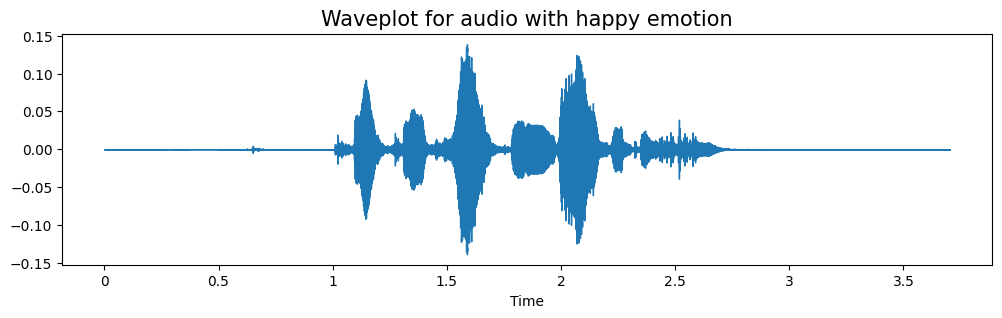

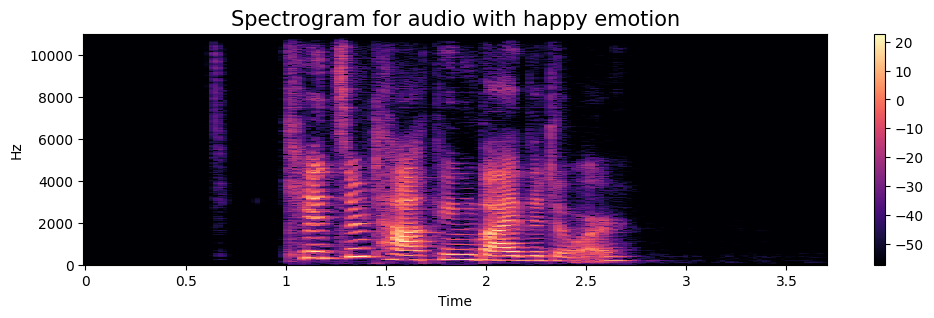

In [45]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(12, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
   
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

emotion='angry'
path = np.array(ref.path[data_path.label==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

emotion='happy'
path = np.array(ref.path[data_path.label==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

# 2. Features exaction

## 2.1. Data augmentation

In [46]:
def noise(data):
    """
    Adding White Noise.
    """
    noise_amp = 0.05*np.random.uniform()*np.amax(data)  
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    

def speedNpitch(data):
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change 
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

## 2.2. Exacting MFCCs features

In [47]:
# # speechNPitch
# def get_mfcc_features(df, n, aug, mfcc): 
#     X = np.empty(shape=(df.shape[0], n*3, 216, 1))
#     input_length = sampling_rate * audio_duration
    
#     cnt = 0
#     for fname in tqdm(df.path):
#         file_path = fname
#         data, _ = librosa.load(file_path, sr=sampling_rate
#                                ,res_type="kaiser_fast"
#                                ,duration=2.5
#                                ,offset=0.5
#                               )

#         if len(data) > input_length:
#             max_offset = len(data) - input_length
#             offset = np.random.randint(max_offset)
#             data = data[offset:(input_length+offset)]
#         else:
#             if input_length > len(data):
#                 max_offset = input_length - len(data)
#                 offset = np.random.randint(max_offset)
#             else:
#                 offset = 0
#             data = np.pad(data, (offset, int(input_length) - len(data) - offset), "constant")

#         if aug == 1:
#             data = speedNpitch(data)
        
#         MFCC = librosa.feature.mfcc(y = data, sr=sampling_rate, n_mfcc=n_mfcc)
#         MFCC_delta1 = librosa.feature.delta(MFCC)
#         MFCC_delta2 = librosa.feature.delta(MFCC, order = 2)
#         feat_all = np.concatenate((MFCC, MFCC_delta1, MFCC_delta2), axis=0).astype('float32')

#         MFCC = np.expand_dims(feat_all, axis=-1)
#         X[cnt,] = MFCC
            
#         cnt += 1
#     return X

# # noise
# def get_mfcc_features2(df, n, aug, mfcc):
    
#     X = np.empty(shape=(df.shape[0], n*3, 216, 1))
#     input_length = sampling_rate * audio_duration
    
#     cnt = 0
#     for fname in tqdm(df.path):
#         file_path = fname
#         data, _ = librosa.load(file_path, sr=sampling_rate
#                                ,res_type="kaiser_fast"
#                                ,duration=2.5
#                                ,offset=0.5
#                               )

#         # Random offset / Padding
#         if len(data) > input_length:
#             max_offset = len(data) - input_length
#             offset = np.random.randint(max_offset)
#             data = data[offset:(input_length+offset)]
#         else:
#             if input_length > len(data):
#                 max_offset = input_length - len(data)
#                 offset = np.random.randint(max_offset)
#             else:
#                 offset = 0
#             data = np.pad(data, (offset, int(input_length) - len(data) - offset), "constant")

#         # Augmentation? 
#         if aug == 1:
#             data = noise(data)
        
#         # which feature?
#         if mfcc == 1:
#             # MFCC extraction 
#             MFCC = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=n_mfcc)
#             MFCC_delta1 = librosa.feature.delta(MFCC)
#             MFCC_delta2 = librosa.feature.delta(MFCC, order = 2)
#             feat_all = np.concatenate((MFCC, MFCC_delta1, MFCC_delta2), axis=0).astype('float32')

#             MFCC = np.expand_dims(feat_all, axis=-1)
#             X[cnt,] = MFCC
            
#         else:
#             # Log-melspectogram
#             melspec = librosa.feature.melspectrogram(data, n_mels = n_melspec)   
#             logspec = librosa.amplitude_to_db(melspec)
#             logspec = np.expand_dims(logspec, axis=-1)
#             X[cnt,] = logspec
            
#         cnt += 1
    
#     return X

In [48]:
# # get features without augmentation
# sampling_rate=44100
# audio_duration=2.5
# n_mfcc = 13
# aug = 0
# mfcc = get_mfcc_features(ref, n_mfcc, aug, mfcc = 1) 

In [49]:
# # get features with augmentation
# sampling_rate=44100
# audio_duration=2.5
# n_mfcc = 13
# mfcc_aug = get_mfcc_features(ref, n = n_mfcc, aug = 1, mfcc = 1)
# mfcc_aug = np.append(mfcc_aug, mfcc, axis=0)
label1 = pd.DataFrame(ref.label)
label2 = pd.DataFrame(ref.label)
result = pd.concat([label1, label2], sort = True)
# result = result.reset_index()
# result = result.drop(['index'], axis=1)
# mfcc_aug2 = get_mfcc_features(ref, n = n_mfcc, aug = 1, mfcc = 1)
# mfcc_aug2 = np.append(mfcc_aug2, mfcc_aug, axis=0)
# label2 = pd.DataFrame(ref.label)
# result2 = pd.concat([result, label2], sort = True)
# result2 = result2.reset_index()
# result2 = result2.drop(['index'], axis=1)

In [50]:
# np.save('/kaggle/working/mfcc_aug2.npy', mfcc_aug2)

In [51]:
mfcc_aug2 = np.load('/kaggle/input/mfcc-features/mfcc_aug2.npy')

label2 = pd.DataFrame(ref.label)
result2 = pd.concat([result, label2], sort = True)
result2 = result2.reset_index()
result2 = result2.drop(['index'], axis=1)

## 2.3. Data normalize

In [52]:
def data_normalization(X_train, X_test, X_val):

    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)

    X_train_norm = (X_train - mean)/std
    X_test_norm = (X_test - mean)/std
    X_val_norm = (X_val - mean)/std
    
    return X_train_norm, X_test_norm, X_val_norm

def np_array_conversation(X_train, y_train, X_test, y_test, X_val, y_val):

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    
    return X_train, y_train, X_test, y_test, X_val, y_val

In [53]:
# Split data to train - val - test
X_train, X_test, y_train, y_test = train_test_split(mfcc_aug2
                                                    , result2
                                                    , test_size=0.3
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

X_train, X_val, y_train, y_val = train_test_split(X_train
                                                  , y_train
                                                  , test_size=0.2
                                                  , shuffle=True
                                                  , random_state=42
                                                 )


## 2.4. Tiền xử lý dữ liệu

In [54]:
# normalize
X_train_norm, X_test_norm, X_val_norm = data_normalization(X_train, X_test, X_val)

In [55]:
from tensorflow.keras.utils import to_categorical

In [56]:
from sklearn.preprocessing import LabelEncoder
# one hot encode the target 
lb = LabelEncoder()
y_train_cat = to_categorical(lb.fit_transform(y_train))    
y_test_cat = to_categorical(lb.fit_transform(y_test))      
y_val_cat = to_categorical(lb.fit_transform(y_val))        
print(X_train.shape)
print(lb.classes_)

(20432, 39, 216, 1)
['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


# 3. Build model

In [57]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
def get_2d_conv_LSTM_model(n):
    nclass = 8
    inp = Input(shape=(n,216,1))  
    x = Convolution2D(64, (3,3), strides=(1, 1), padding="same")(inp)    
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(128, (3,3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(256, (3,3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(128, (3,3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Reshape((-1, 128))(x)
    
    #LSTM
    x = LSTM(128)(x)
    
    out = Dense(nclass, activation=softmax)(x)
    model = models.Model(inputs=inp, outputs=out)
    
    opt = tf.keras.optimizers.Adam(learning_rate = 0.0001, decay=1e-6)
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

In [58]:
n_mfcc = 13
model = get_2d_conv_LSTM_model(n_mfcc*3)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 39, 216, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 39, 216, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 39, 216, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 39, 216, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 19, 108, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 19, 108, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 19, 108, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 19, 108, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 19, 108, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 54, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 9, 54, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 9, 54, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 9, 54, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 9, 54, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 27, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 27, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 27, 128)     │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 4, 27, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 4, 27, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 13, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 2, 13, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 26, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,58

 Total params: 799,624 (3.05 MB)

 Trainable params: 798,472 (3.05 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [59]:
# model_name = 'cnn_lstm.h5'
# model_path = "/kaggle/working/"
# print('Save model and weights at %s ' % model_path)
model_history = model.fit(X_train_norm, y_train_cat, validation_data=(X_val_norm, y_val_cat), batch_size=32,
                          verbose = 1, epochs=75)

Epoch 1/75


2024-05-14 05:07:20.271663: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_3_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


639/639 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - acc: 0.2300 - loss: 1.8821 - val_acc: 0.3389 - val_loss: 1.6673
Epoch 2/75
639/639 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - acc: 0.4113 - loss: 1.4919 - val_acc: 0.3910 - val_loss: 1.5670
Epoch 3/75
639/639 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - acc: 0.4845 - loss: 1.3353 - val_acc: 0.4614 - val_loss: 1.3519
Epoch 4/75
639/639 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - acc: 0.5168 - loss: 1.2520 - val_acc: 0.3743 - val_loss: 1.5437
Epoch 5/75
639/639 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - acc: 0.5531 - loss: 1.1682 - val_acc: 0.4959 - val_loss: 1.2568
Epoch 6/75
639/639 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - acc: 0.5635 - loss: 1.1240 - val_acc: 0.5176 - val_loss: 1.2682
Epoch 7/75
639/639 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - acc: 0.5906 - loss: 1.0706 - val_acc: 0.4485 - val_loss: 1.3558
Epoch 8/75
639/639 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - acc: 0.5960 - loss: 1.0441 - val_acc: 0.6112 - val_loss: 1.0380
Epoch 9/75
639/639 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/st

In [60]:
tf.keras.models.save_model(model, '/kaggle/working/model_75.h5')

# 4. Evalute

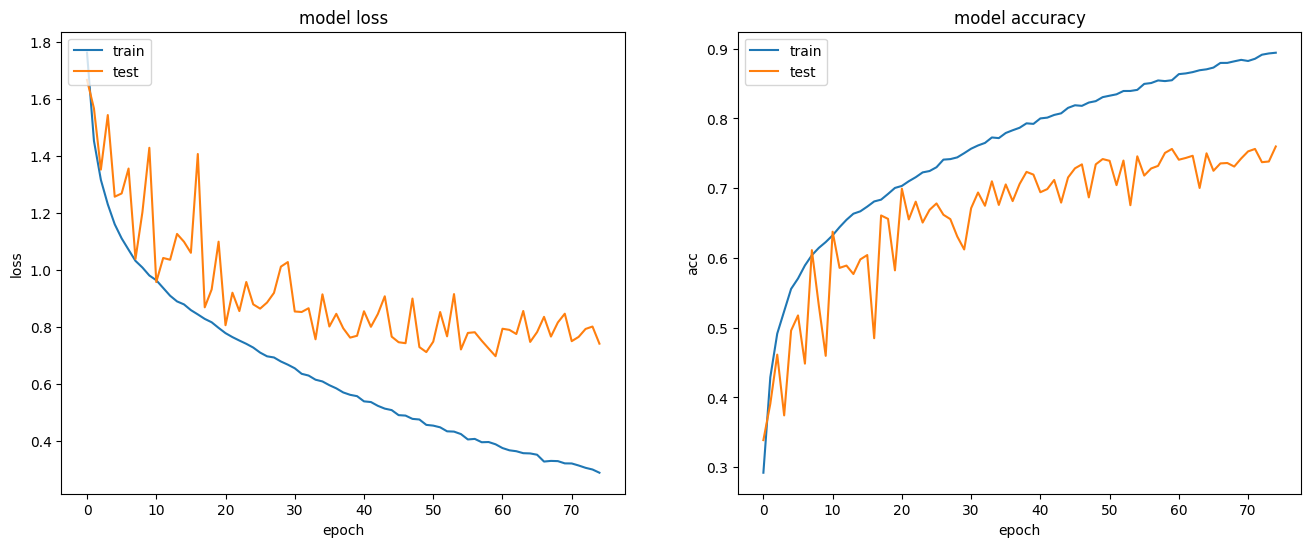

In [61]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))
titles = ['model loss', 'model accuracy']
a = ['loss', 'acc']

for i in range(2):
    ax_i = ax[i]
    ax_i.plot(model_history.history[a[i]])
    ax_i.plot(model_history.history['val_' + a[i]])
    ax_i.set_title(titles[i])
    ax_i.set_ylabel(a[i])
    ax_i.set_xlabel('epoch')
    ax_i.legend(['train', 'test'], loc='upper left')   

In [62]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6)
model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
test_loss, test_acc = model.evaluate(X_test_norm, y_test_cat, verbose=0)
print("Test Accuracy: ",test_acc)
print("Test loss: ",test_loss) 
score = model.evaluate(X_test_norm, y_test_cat, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Test Accuracy:  0.7616481184959412
Test loss:  0.7362878322601318
343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - acc: 0.7584 - loss: 0.7414
compile_metrics: 76.16%


In [63]:
from sklearn.metrics import classification_report

preds = model.predict(X_test_norm, 
                              batch_size=16, 
                              verbose=1)
preds=preds.argmax(axis=1)
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})# new temp code
        
actual = y_test_cat.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual}) ## new temp code
        
finaldf = actual.join(preds)
labels = finaldf.actualvalues.unique()        
    
classes = labels
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
              precision    recall  f1-score   support

       angry       0.82      0.86      0.84      1765
        calm       0.69      0.94      0.80       154
     disgust       0.80      0.68      0.74      1722
        fear       0.74      0.69      0.71      1747
       happy       0.77      0.72      0.75      1683
     neutral       0.74      0.83      0.78      1513
         sad       0.66      0.77      0.71      1747
    surprise       0.98      0.77      0.86       615

    accuracy                           0.76     10946
   macro avg       0.78      0.78      0.77     10946
weighted avg       0.77      0.76      0.76     10946

